Con respecto a tu notebook te puedo comentar dos cosas:
    - La constante K del muelle la estás metiendo con unidades repetidas en la fuerza para definir el sistema. Lo que no entiendo es por qué OpenMM no se quejó.
    - Dado que estamos definiendo la energía como kcal/mol necesitamos (mira la K del muelle por ejemplo) que KbT tenga unidades compatibles. Por eso hacemos que:
    
```python
KbT = unit.BOLTZMANN_CONSTANT_kB * unit.AVOGADRO_CONSTANT_NA * temperature
```

Espero que este notebook te ayude a completar el tuyo:

In [1]:
import openmm
import openmm.app as app
import openmm.unit as unit

import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

In [2]:
CARBON_MASS = 12.010 * unit.amu
OXYGEN_MASS = 15.999 * unit.amu

In [3]:
n_particles = 1
mass = (CARBON_MASS * OXYGEN_MASS) / (CARBON_MASS + OXYGEN_MASS)

# Topology

topology = app.Topology()

dummy_element = app.Element(0, 'DUM', 'DUM', 0.0 * unit.amu)

chain = topology.addChain('A')
for ii in range(n_particles):
    residue = topology.addResidue('DUM', chain)
    atom = topology.addAtom(name='DUM', element= dummy_element, residue=residue)

In [4]:
# System

system = openmm.System()
system.addParticle(mass)

K = 10.0 * unit.kilocalorie_per_mole/unit.nanometers**2

# Add the harmonic potential
force = openmm.CustomExternalForce('(K/2.0) * (x^2 + y^2 + z^2)')
force.addGlobalParameter('K', K)
force.addParticle(0)

system.addForce(force)

0

In [5]:
# Simulation

temperature = 300*unit.kelvin
friction = 1.0/unit.picosecond
step = 0.01*unit.picosecond

integrator = openmm.LangevinIntegrator(temperature, friction, step)

platform = openmm.Platform.getPlatformByName('CUDA')

simulation = app.Simulation(topology, system, integrator, platform)

In [6]:
# Initial conditions

pos = np.zeros((1, 3), np.float32) * unit.angstroms
vel = np.ones((1, 3), np.float32)  * unit.angstroms/unit.picoseconds

simulation.context.setPositions(pos)
simulation.context.setVelocities(vel)

In [7]:
# Running the simulation

sim_time = 10.0 * unit.nanosecond
save_time = 1.0 * unit.picosecond

n_steps_per_period = int(save_time/step)
n_periods = int(sim_time/save_time)

time = np.zeros([n_periods], np.float32) * unit.picoseconds
position = np.zeros([n_periods, 1, 3], np.float32) * unit.angstroms
velocity = np.zeros([n_periods, 1, 3], np.float32) * unit.angstroms/unit.picosecond
pot_energy = np.zeros([n_periods], np.float32) * unit.kilocalorie_per_mole
kin_energy = np.zeros([n_periods], np.float32) * unit.kilocalorie_per_mole

for ii in tqdm(range(n_periods)):
    simulation.step(n_steps_per_period)
    state = simulation.context.getState( getPositions=True, getVelocities=True, getEnergy=True)
    time[ii] = state.getTime()
    position[ii] = state.getPositions()
    velocity[ii] = state.getVelocities()
    pot_energy[ii] = state.getPotentialEnergy()
    kin_energy[ii] = state.getKineticEnergy()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 334.00it/s]


In [8]:
# Theoretical probability density
x = np.linspace(-10, 10, 500) * unit.angstroms
KbT = unit.BOLTZMANN_CONSTANT_kB * unit.AVOGADRO_CONSTANT_NA * temperature
prob = np.sqrt(K/(2.0*np.pi*KbT)) * np.exp(-(1.0/KbT)*0.5*K*x**2)

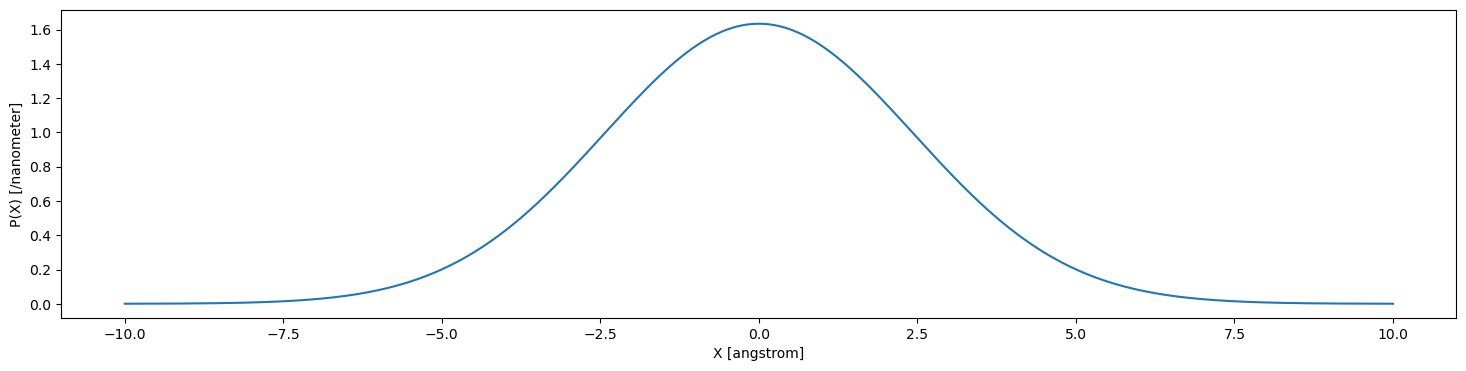

In [9]:
plt.rcParams['figure.figsize'] = 18, 4
plt.plot(x, prob)
plt.ylabel("P(X) [{}]".format(prob.unit))
plt.xlabel('X [{}]'.format(x.unit))
plt.show()

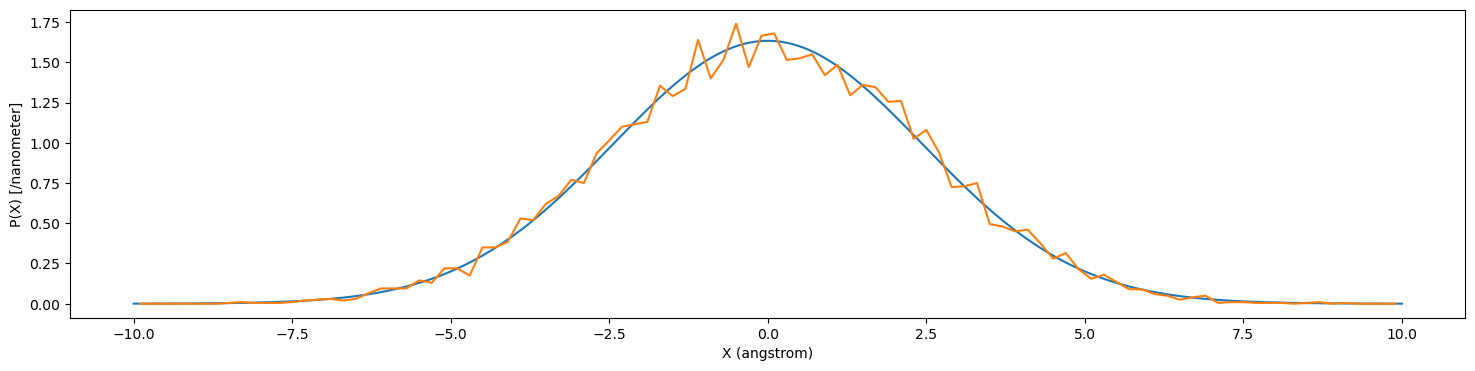

In [15]:
# Comparison with the experimental probability density

def occupation_probability_density_1d(traj_x, x_range, n_bins):
    delta_x = (x_range[1]-x_range[0])/n_bins
    frequency = np.zeros(n_bins, dtype=int)
    for x in traj_x:
        bin_visited = int((x-x_range[0])/delta_x)
        frequency[bin_visited]+=1
    x_bins_centers = (x_range[0]+0.5*delta_x) + delta_x*np.arange(n_bins)
    bins_probability_density = (1.0/delta_x)*(frequency/frequency.sum())
    return x_bins_centers, bins_probability_density

x_center_bin, px = occupation_probability_density_1d(position[:,0,0], [-1,1]*unit.nanometer, 100)

plt.rcParams['figure.figsize'] = 18, 4
plt.plot(x, prob)
plt.plot(x_center_bin.in_units_of(unit.angstrom), px)
plt.ylabel("P(X) [{}]".format(prob.unit))
plt.xlabel('X ({})'.format(x.unit))
plt.show()